In [2]:
import numpy as np
import os, sys, librosa
from librosa import display
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd
from numba import jit
from IPython.display import Audio 
import IPython

import cdpam

from scipy.stats import pearsonr, spearmanr

import scipy.spatial as sp

import torch
import torch.nn as nn
import torch.fft
from torch.autograd import Variable
import torch.optim as optim
import numpy as np

import noisereduce as nr

import librosa
from IPython.display import Audio, display
from PIL import Image
import matplotlib.pyplot as plt
import scipy.stats as stats
import collections as c

from tifresi.utils import load_signal
from tifresi.utils import preprocess_signal
from tifresi.stft import GaussTF, GaussTruncTF
from tifresi.transforms import log_spectrogram
from tifresi.transforms import inv_log_spectrogram

from torch.nn.modules.module import _addindent

import copy
import os
import math

import soundfile as sf
from matplotlib.pyplot import figure
import pickle

from sklearn.preprocessing import MinMaxScaler
import glob

import sys
sys.path.insert(0, '../../')
import dnnlib
from utils import util, training_utils, losses, masking, gmloss
from networks import stylegan_encoder

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


from scipy.signal import freqz,butter, lfilter

%load_ext autoreload
%autoreload 2

In [3]:
network_pkl = '/home/purnima/appdir/Github/StyleGANs/audio-stylegan2/training-runs/vis-data-256-split/00000/network-snapshot-002800.pkl'

sample_rate = 16000
stft_channels = 512 #510
n_frames = 256
hop_size = 128
sample_rate = 16000
        
device = torch.device('cuda')
with open(network_pkl, 'rb') as pklfile:
    network = pickle.load(pklfile)
    G = network['G'].to(device).eval()


    
    
encoder_pt = '../../checkpoints/sgan_encoder_greatesthits_resnet-34_RGBM-corrected/netE_epoch_best.pth'

# netE = stylegan_encoder.load_stylegan_encoder(domain=None, nz=G.z_dim,
#                                                    outdim=128,
#                                                    use_RGBM=True,#opt.masked,
#                                                    use_VAE=False,#opt.vae_like,
#                                                    resnet_depth=34,
#                                                    ckpt_path=encoder_pt)
# netE = netE.to(device).eval()



encoder_pt_nolpips = '/home/purnima/appdir/Github/audio-latent-composition/checkpoints/sgan_encoder_greatesthits_resnet-34_RGBM-corrected-nolpips/netE_epoch_best.pth'
netE = stylegan_encoder.load_stylegan_encoder(domain=None, nz=G.z_dim,
                                                   outdim=128,
                                                   use_RGBM=True,#opt.masked,
                                                   use_VAE=False,#opt.vae_like,
                                                   resnet_depth=34,
                                                   ckpt_path=encoder_pt_nolpips)
netE = netE.to(device).eval()


Using halfsize?: False
Input channels: 2


In [4]:
def applyFBFadeFilter(forward_fadetime,backward_fadetime,signal,fs,expo=1):
    forward_num_fad_samp = int(forward_fadetime*fs) 
    backward_num_fad_samp = int(backward_fadetime*fs) 
    signal_length = len(signal) 
    fadefilter = np.ones(signal_length)
    if forward_num_fad_samp>0:
        fadefilter[0:forward_num_fad_samp]=np.linspace(0,1,forward_num_fad_samp)**expo
    if backward_num_fad_samp>0:
        fadefilter[signal_length-backward_num_fad_samp:signal_length]=np.linspace(1,0,backward_num_fad_samp)**expo
    return fadefilter*signal

def pghi_stft(x):
    use_truncated_window = True
    if use_truncated_window:
        stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)
    else:
        stft_system = GaussTF(hop_size=hop_size, stft_channels=stft_channels)
    Y = stft_system.spectrogram(x)
    log_Y= log_spectrogram(Y)
    return np.expand_dims(log_Y,axis=0)

def zeropad(signal, audio_length):
    if len(signal) < audio_length:
        return np.append(
            signal, 
            np.zeros(audio_length - len(signal))
        )
    else:
        signal = signal[0:audio_length]
        return signal

def pghi_istft(x):
    use_truncated_window = True
    if use_truncated_window:
        stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)
    else:
        stft_system = GaussTF(hop_size=hop_size, stft_channels=stft_channels)

    x = np.squeeze(x,axis=0)
    new_Y = inv_log_spectrogram(x)
    new_y = stft_system.invert_spectrogram(new_Y)
    return new_y

def renormalize(n, range1, range2):
    delta1 = range1[1] - range1[0]
    delta2 = range2[1] - range2[0]
    return (delta2 * (n - range1[0]) / delta1) + range2[0]

def read_and_plot(f, title=None):
    y, sr = librosa.load(f, sr=sample_rate)
    plot(y, title)

def plot(y, title=None):
    IPython.display.display(IPython.display.Audio(y, rate=sample_rate))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    
    y_pghi = y
    y_pghi = preprocess_signal(y_pghi)
    y_pghi = zeropad(y_pghi, n_frames * hop_size )
    y_pghi = pghi_stft(y_pghi)
    
    a=librosa.display.specshow(y_pghi[0],x_axis='time', y_axis='linear', ax=ax[0], sr=sample_rate, hop_length=hop_size)
    ax[0].set_title(title)
    
    ax[1].plot(y)
    
def plot_multi(y1, y2, title1=None, title2=None):
    IPython.display.display(IPython.display.Audio(y1, rate=sample_rate))
    IPython.display.display(IPython.display.Audio(y2, rate=sample_rate))
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    
    y_pghi = y1
    y_pghi = preprocess_signal(y_pghi)
    y_pghi = zeropad(y_pghi, n_frames * hop_size )
    y_pghi = pghi_stft(y_pghi)
    
    a=librosa.display.specshow(y_pghi[0],x_axis='time', y_axis='linear', ax=ax[0], sr=sample_rate, hop_length=hop_size)
    ax[0].set_title(title1)
    
    y_pghi = y2
    y_pghi = preprocess_signal(y_pghi)
    y_pghi = zeropad(y_pghi, n_frames * hop_size )
    y_pghi = pghi_stft(y_pghi)
    
    a=librosa.display.specshow(y_pghi[0],x_axis='time', y_axis='linear', ax=ax[1], sr=sample_rate, hop_length=hop_size)
    ax[1].set_title(title2)
    


In [8]:
z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
im = G(z, None)
im_min = torch.min(im).cpu().numpy()
im_max = torch.max(im).cpu().numpy()
print(im_min, im_max)

pghi_min = -50.0
pghi_max = 0.0

np.random.seed(123)


-1.0550117 0.99423987


In [9]:
def encode_and_reconstruct(audio):
    audio_pghi = preprocess_signal(audio)
    audio_pghi = zeropad(audio_pghi, n_frames * hop_size )
    audio_pghi = pghi_stft(audio_pghi)
    audio_pghi = renormalize(audio_pghi, (np.min(audio_pghi), np.max(audio_pghi)), (im_min, im_max))

    audio_pghi = torch.from_numpy(audio_pghi).float().cuda().unsqueeze(dim=0)
    mask = torch.ones_like(audio_pghi)[:, :1, :, :]
    net_input = torch.cat([audio_pghi, mask], dim=1).cuda()
    with torch.no_grad():
        encoded = netE(net_input)

    reconstructed_audio = G.synthesis(torch.stack([encoded] * 14, dim=1))
    filler = torch.full((1, 1, 1, reconstructed_audio[0].shape[1]), torch.min(reconstructed_audio)).cuda()
    reconstructed_audio = torch.cat([reconstructed_audio, filler], dim=2)
    reconstructed_audio = renormalize(reconstructed_audio, (torch.min(reconstructed_audio), torch.max(reconstructed_audio)), (pghi_min, pghi_max))
    reconstructed_audio = reconstructed_audio.detach().cpu().numpy()[0]
    reconstructed_audio_wav = pghi_istft(reconstructed_audio)
    
    return encoded, reconstructed_audio_wav

def get_spectrogram(audio):
    audio_pghi = preprocess_signal(audio)
    audio_pghi = zeropad(audio_pghi, n_frames * hop_size )
    audio_pghi = pghi_stft(audio_pghi)
    return audio_pghi


In [10]:
rate_locs_0_per_sec = [0.05]
rate_locs_1_per_sec = [0.05, 1.05]
rate_locs_2_per_sec = [0.05, 0.9, 1.75]
rate_locs_3_per_sec = [0.05, 0.45, 0.85, 1.25, 1.65]
rate_locs_4_per_sec = [0.05, 0.35, 0.65, 0.95, 1.25, 1.55, 1.85]

In [11]:
def butter_bandpass(lowcut, highcut, fs, order=5,btype='bandpass'):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype=btype)
    return b, a

def butter_lowhighpass(cut, fs, order=5, btype='lowpass'):
    nyq = 0.5 * fs
    cut = cut / nyq
    b, a = butter(order, cut, btype=btype)
    return b, a

def butter_bandpass_filter(data, highcut, fs,lowcut=None,  order=5, btype='bandpass'):
    if btype=='bandpass':
        b, a = butter_bandpass(lowcut, highcut, fs, order=order, btype=btype)
    else:
        b, a = butter_lowhighpass(highcut, fs, order=order, btype=btype)
    y = lfilter(b, a, data)
    return y

def gaver_impact_solidbar_single(initial_amplitude, impulse_time, num_partials, size='small', metal_or_plastic='metal', samplerate=16000):
    t_ = np.linspace(0,impulse_time,int(impulse_time*samplerate))
    
    omega_1 = 240 #In Hz. Frequency is inversely proportional to size
    if size == 'small':
        omega_1 = 660
        
    D = 0.001
    if metal_or_plastic == 'plastic':
        D = 0.5
    
    h=[h_ for h_ in np.arange(-0.005, 0.005, (0.005+0.005)/num_partials)][::-1]
    
    gn=np.zeros(int(impulse_time*samplerate))
    for i in range(num_partials):
        omega_n_radians = omega_1*((2*i + 1)**2)/9
        
        phi = initial_amplitude + h[i]*(omega_n_radians - (2*np.pi*omega_1))
        
        delta_n = omega_n_radians * D
        g = phi * np.exp(-1*delta_n*t_) * np.cos(omega_n_radians * t_)
        gn = gn + g
    return gn


def gaver_impact_plate_single(initial_amplitude, impulse_time, num_partials, size='small', metal_or_plastic='metal', samplerate=16000):
    t_ = np.linspace(0,impulse_time,int(impulse_time*samplerate))
    
    omega_1 = 60 #In Hz. Frequency is inversely proportional to size
    if size == 'small':
        omega_1 = 250
        
    D = 0.001
    if metal_or_plastic == 'plastic':
        D = 0.3
    
    h=[h_ for h_ in np.arange(-0.005, 0.005, (0.005+0.005)/num_partials)][::-1]
    
    gn=np.zeros(int(impulse_time*samplerate))
    for i in range(num_partials):
        omega_n = omega_1 + i*omega_1 + np.random.randint(50)
        omega_n_radians = 2 * np.pi * omega_n
        
        phi = initial_amplitude + h[i]*(omega_n_radians - (2*np.pi*omega_1))
        
        delta_n = omega_n_radians * D
        g = phi * np.exp(-1*delta_n*t_) * np.cos(omega_n_radians * t_)
        gn = gn + g
    return gn
    
def gaver_impact_plate(initial_amplitude, impulse_time, num_partials, size='small', metal_or_plastic='metal', samplerate=16000, total_time=0, locs=None):
    single_hit = gaver_impact_plate_single(initial_amplitude, impulse_time, num_partials, size, metal_or_plastic, samplerate)
    gn=np.zeros(int(total_time*samplerate))
    for loc in locs:
        start_loc = int(loc*sample_rate)
        end_loc = start_loc+len(single_hit)
        single_hit_ = single_hit

        if end_loc > len(gn):
            end_loc = len(gn)
            single_hit_ = single_hit_[0:end_loc-start_loc]

        gn[start_loc:end_loc] = applyFBFadeFilter(forward_fadetime=0.2,backward_fadetime=0,signal=single_hit_,fs=sample_rate)

    return gn/np.max(gn)

def gaver_impact_solidbar(initial_amplitude, impulse_time, num_partials, size='small', metal_or_plastic='metal', samplerate=16000, total_time=0, locs=None):
    single_hit = gaver_impact_solidbar_single(initial_amplitude, impulse_time, num_partials, size, metal_or_plastic, samplerate)
    gn=np.zeros(int(total_time*samplerate))
    for loc in locs:
        start_loc = int(loc*sample_rate)
        end_loc = start_loc+len(single_hit)
        single_hit_ = single_hit

        if end_loc > len(gn):
            end_loc = len(gn)
            single_hit_ = single_hit_[0:end_loc-start_loc]

        gn[start_loc:end_loc] = applyFBFadeFilter(forward_fadetime=0.05,backward_fadetime=0,signal=single_hit_,fs=sample_rate)

    return gn/np.max(gn)

In [12]:

#filters = [(low1, high1), (low2, high2)]
def get_gaver_scratches(initial_amplitude, impulse_time, filters, total_time=2, locs=None, sample_rate=16000, hittype='hit'):
    y_scratch = np.random.rand(int(impulse_time*sample_rate))
    
    #20%
    start_t = 0.0
    end_t = 0.05*impulse_time
    fade_expo = 1
    y1 = initial_amplitude*y_scratch[int(start_t*sample_rate):int(end_t*sample_rate)]
    y1 = 20*butter_bandpass_filter(y1, lowcut=filters[0][0], highcut=filters[0][1], fs=sample_rate, order=2, btype='bandpass')
    y1 = applyFBFadeFilter(0,0.1*(end_t-start_t),y1,sample_rate, expo=fade_expo)
    y1 = np.pad(y1, (int(start_t*sample_rate),len(y_scratch)-int(end_t*sample_rate)), mode='constant')
    
    #Remaining 80%
    start_t = 0.05*impulse_time
    end_t = 1.0*impulse_time
    fade_expo = 1
    y2 = initial_amplitude*y_scratch[int(start_t*sample_rate):int(end_t*sample_rate)]
    y2 = 10*butter_bandpass_filter(y2, lowcut=filters[1][0], highcut=filters[1][1], fs=sample_rate, order=2, btype='bandpass')
    y2 = applyFBFadeFilter(0,0.1*(end_t-start_t),y2,sample_rate, expo=fade_expo)
    y2 = np.pad(y2, (int(start_t*sample_rate),len(y_scratch)-int(end_t*sample_rate)), mode='constant')
    
    
    y_scratch = y1+y2
    
    signal_mult = 0.00005
    if hittype == 'scratch':
        signal_mult = 0.0005
    signal = signal_mult*np.random.randn(int(total_time*sample_rate))
    
    for loc in locs:
        start_loc = int(loc*sample_rate)
        end_loc = start_loc+len(y_scratch)
        y_scratch_ = y_scratch

        if end_loc > len(signal):
            end_loc = len(signal)
            y_scratch_ = y_scratch_[0:end_loc-start_loc]

        signal[start_loc:end_loc] = y_scratch_
    return signal/np.max(signal)

In [13]:
gaver_config = {}
gaver_config['hit_tinny_sample0_rate0'] = {'impulse_time': 0.4, 'attack_lf': 2000, 'attack_hf': 7500, 'trail_lf': 5000, 'trail_hf': 7500 }
gaver_config['hit_tinny_sample0_rate1'] = {'impulse_time': 0.2, 'attack_lf': 2000, 'attack_hf': 7500, 'trail_lf': 7000, 'trail_hf': 7500 }
gaver_config['hit_tinny_sample0_rate2'] = {'impulse_time': 0.2 , 'attack_lf': 2000, 'attack_hf': 7500, 'trail_lf': 7000, 'trail_hf': 7500 }
gaver_config['hit_tinny_sample0_rate3'] = {'impulse_time': 0.1, 'attack_lf': 2000, 'attack_hf': 7500, 'trail_lf': 2000, 'trail_hf': 7500}
gaver_config['hit_tinny_sample0_rate4'] = {'impulse_time': 0.05, 'attack_lf': 500, 'attack_hf': 7500, 'trail_lf': 5000, 'trail_hf': 7500}

gaver_config['hit_tinny_sample1_rate0'] = {'impulse_time': 0.5, 'attack_lf': 200, 'attack_hf': 7500, 'trail_lf': 200, 'trail_hf': 7500  }
gaver_config['hit_tinny_sample1_rate1'] = {'impulse_time': 0.3, 'attack_lf': 200, 'attack_hf': 7500, 'trail_lf': 200, 'trail_hf': 7500  }
gaver_config['hit_tinny_sample1_rate2'] = {'impulse_time': 0.3, 'attack_lf': 200, 'attack_hf': 7500, 'trail_lf': 200, 'trail_hf': 7500 }
gaver_config['hit_tinny_sample1_rate3'] = {'impulse_time': 0.1, 'attack_lf': 10, 'attack_hf': 7500, 'trail_lf': 7000, 'trail_hf': 7500 }
gaver_config['hit_tinny_sample1_rate4'] = {'impulse_time': 0.1, 'attack_lf': 500, 'attack_hf': 7500, 'trail_lf': 5000, 'trail_hf': 7500}


gaver_config['hit_muffled_sample0_rate0'] = {'impulse_time': 0.2, 'attack_lf': 200, 'attack_hf': 500, 'trail_lf': 200, 'trail_hf': 500 }
gaver_config['hit_muffled_sample0_rate1'] = {'impulse_time': 0.2, 'attack_lf': 200, 'attack_hf': 500, 'trail_lf': 200, 'trail_hf': 500 }
gaver_config['hit_muffled_sample0_rate2'] = {'impulse_time': 0.2, 'attack_lf': 200, 'attack_hf': 500, 'trail_lf': 200, 'trail_hf': 500 }
gaver_config['hit_muffled_sample0_rate3'] = {'impulse_time': 0.2, 'attack_lf': 200, 'attack_hf': 500, 'trail_lf': 200, 'trail_hf': 500 }
gaver_config['hit_muffled_sample0_rate4'] = {'impulse_time': 0.035, 'attack_lf': 20, 'attack_hf': 1200, 'trail_lf': 1000, 'trail_hf': 2200 }

gaver_config['hit_muffled_sample1_rate0'] = {'impulse_time': 0.3, 'attack_lf': 10, 'attack_hf': 1500, 'trail_lf': 10, 'trail_hf': 1500 }
gaver_config['hit_muffled_sample1_rate1'] = {'impulse_time': 0.3, 'attack_lf': 10, 'attack_hf': 1500, 'trail_lf': 10, 'trail_hf': 1500 }
gaver_config['hit_muffled_sample1_rate2'] = {'impulse_time': 0.3, 'attack_lf': 10, 'attack_hf': 1500, 'trail_lf': 10, 'trail_hf': 1500 }
gaver_config['hit_muffled_sample1_rate3'] = {'impulse_time': 0.05, 'attack_lf': 10, 'attack_hf': 1500, 'trail_lf': 10, 'trail_hf': 1500 }
gaver_config['hit_muffled_sample1_rate4'] =  {'impulse_time': 0.05, 'attack_lf': 1000, 'attack_hf': 4000, 'trail_lf': 1000, 'trail_hf': 4000 }




gaver_config['scratch_tinny_sample0_rate0'] = {'impulse_time': 0.9 , 'attack_lf': 400, 'attack_hf': 7900, 'trail_lf': 6500, 'trail_hf': 7900 }
gaver_config['scratch_tinny_sample0_rate1'] = {'impulse_time': 0.9 , 'attack_lf': 400, 'attack_hf': 7900, 'trail_lf': 6500, 'trail_hf': 7900 }
gaver_config['scratch_tinny_sample0_rate2'] = {'impulse_time': 0.8 , 'attack_lf': 400, 'attack_hf': 7900, 'trail_lf': 6500, 'trail_hf': 7900 }
gaver_config['scratch_tinny_sample0_rate3'] = {'impulse_time': 0.3 , 'attack_lf': 400, 'attack_hf': 7900, 'trail_lf': 6000, 'trail_hf': 7900 }
gaver_config['scratch_tinny_sample0_rate4'] = {'impulse_time': 0.2 , 'attack_lf': 400, 'attack_hf': 7900, 'trail_lf': 5000, 'trail_hf': 7900 }

gaver_config['scratch_tinny_sample1_rate0'] = {'impulse_time': 0.9, 'attack_lf': 6900, 'attack_hf': 7900, 'trail_lf': 6900, 'trail_hf': 7900 }
gaver_config['scratch_tinny_sample1_rate1'] = {'impulse_time': 0.9, 'attack_lf': 6900, 'attack_hf': 7900, 'trail_lf': 6900, 'trail_hf': 7900 }
gaver_config['scratch_tinny_sample1_rate2'] = {'impulse_time': 0.8, 'attack_lf': 6900, 'attack_hf': 7900, 'trail_lf': 6900, 'trail_hf': 7900 }
gaver_config['scratch_tinny_sample1_rate3'] = {'impulse_time': 0.25, 'attack_lf': 6900, 'attack_hf': 7900, 'trail_lf': 6900, 'trail_hf': 7900 }
gaver_config['scratch_tinny_sample1_rate4'] = {'impulse_time': 0.17, 'attack_lf': 1500, 'attack_hf': 7900, 'trail_lf': 1500, 'trail_hf': 7900 }



gaver_config['scratch_muffled_sample0_rate0'] = {'impulse_time': 0.3, 'attack_lf': 10, 'attack_hf': 70, 'trail_lf': 100, 'trail_hf': 2000 }
gaver_config['scratch_muffled_sample0_rate1'] = {'impulse_time': 0.7, 'attack_lf': 10, 'attack_hf': 70, 'trail_lf': 100, 'trail_hf': 2000 }
gaver_config['scratch_muffled_sample0_rate2'] = {'impulse_time': 0.6, 'attack_lf': 10, 'attack_hf': 70, 'trail_lf': 100, 'trail_hf': 2000 }
gaver_config['scratch_muffled_sample0_rate3'] = {'impulse_time': 0.25, 'attack_lf': 100, 'attack_hf': 1000, 'trail_lf': 100, 'trail_hf': 1000 }
gaver_config['scratch_muffled_sample0_rate4'] = {'impulse_time': 0.15, 'attack_lf': 100, 'attack_hf': 1000, 'trail_lf': 100, 'trail_hf': 1000 }

gaver_config['scratch_muffled_sample1_rate0'] = {'impulse_time': 0.7, 'attack_lf': 100, 'attack_hf': 150, 'trail_lf': 100, 'trail_hf': 350 }
gaver_config['scratch_muffled_sample1_rate1'] = {'impulse_time': 0.75, 'attack_lf': 20, 'attack_hf': 150, 'trail_lf': 20, 'trail_hf': 1800 }
gaver_config['scratch_muffled_sample1_rate2'] = {'impulse_time': 0.65, 'attack_lf': 20, 'attack_hf': 150, 'trail_lf': 20, 'trail_hf': 1800 }
gaver_config['scratch_muffled_sample1_rate3'] = {'impulse_time': 0.3, 'attack_lf': 20, 'attack_hf': 150, 'trail_lf': 20, 'trail_hf': 1800 }
gaver_config['scratch_muffled_sample1_rate4'] = {'impulse_time': 0.17, 'attack_lf': 700, 'attack_hf': 1700, 'trail_lf': 700, 'trail_hf': 1700 }


In [15]:
rate_locs_0_per_sec = [0.05]
rate_locs_1_per_sec = [0.05, 1.05]
rate_locs_2_per_sec = [0.05, 0.9, 1.75]
rate_locs_3_per_sec = [0.05, 0.45, 0.85, 1.25, 1.65]
rate_locs_4_per_sec = [0.05, 0.35, 0.65, 0.95, 1.25, 1.55, 1.85]


list_of_materials = ['tinny', 'muffled']
# list_of_materials = ['tinny']
#Materials go from tinnier to muffled

file_dict = {}

for key in gaver_config.keys():
    
    rate_str = int(key.split('_')[-1][-1])
    rate = rate_locs_0_per_sec
    if rate_str == 1:
        rate = rate_locs_1_per_sec
    if rate_str == 2:
        rate = rate_locs_2_per_sec
    if rate_str == 3:
        rate = rate_locs_3_per_sec
    if rate_str == 4:
        rate = rate_locs_4_per_sec
        
    
    config = gaver_config[key]

    gaver_audio = get_gaver_scratches(initial_amplitude=1, impulse_time=config['impulse_time'], \
                                      filters= [(config['attack_lf'], config['attack_hf']), (config['trail_lf'], config['trail_hf'])], total_time=2, \
                                            locs=rate, sample_rate=sample_rate, hittype='hit')

    encoded, reconstructed_audio = encode_and_reconstruct(gaver_audio)
    file_dict[key] = {'audio':gaver_audio, 'reconstructed_audio':reconstructed_audio}



In [16]:
file_dict.keys()

dict_keys(['hit_tinny_sample0_rate0', 'hit_tinny_sample0_rate1', 'hit_tinny_sample0_rate2', 'hit_tinny_sample0_rate3', 'hit_tinny_sample0_rate4', 'hit_tinny_sample1_rate0', 'hit_tinny_sample1_rate1', 'hit_tinny_sample1_rate2', 'hit_tinny_sample1_rate3', 'hit_tinny_sample1_rate4', 'hit_muffled_sample0_rate0', 'hit_muffled_sample0_rate1', 'hit_muffled_sample0_rate2', 'hit_muffled_sample0_rate3', 'hit_muffled_sample0_rate4', 'hit_muffled_sample1_rate0', 'hit_muffled_sample1_rate1', 'hit_muffled_sample1_rate2', 'hit_muffled_sample1_rate3', 'hit_muffled_sample1_rate4', 'scratch_tinny_sample0_rate0', 'scratch_tinny_sample0_rate1', 'scratch_tinny_sample0_rate2', 'scratch_tinny_sample0_rate3', 'scratch_tinny_sample0_rate4', 'scratch_tinny_sample1_rate0', 'scratch_tinny_sample1_rate1', 'scratch_tinny_sample1_rate2', 'scratch_tinny_sample1_rate3', 'scratch_tinny_sample1_rate4', 'scratch_muffled_sample0_rate0', 'scratch_muffled_sample0_rate1', 'scratch_muffled_sample0_rate2', 'scratch_muffled_sam

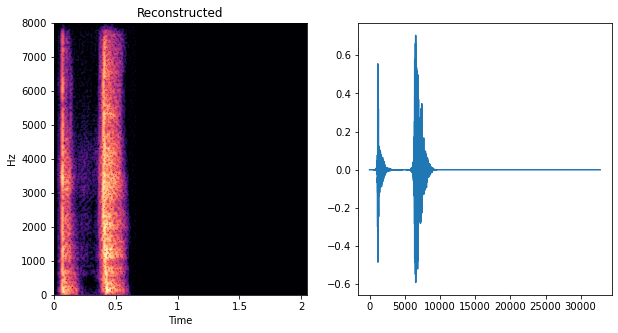

In [27]:
reconstructed_audio = file_dict['hit_tinny_sample0_rate0']['reconstructed_audio']
plot(reconstructed_audio, f'Reconstructed')

In [17]:

dirname = 'regenerated_gaver'

os.makedirs(dirname, exist_ok=True)

for key in file_dict.keys():
    
    filename = key + '.wav'
    audio = file_dict[key]['audio']
    reconstructed_audio = file_dict[key]['reconstructed_audio']

    sf.write(os.path.join(dirname, filename), audio, samplerate=sample_rate)
    sf.write(os.path.join(dirname, 'reconstructed_'+filename), reconstructed_audio, samplerate=sample_rate)

    fig = plt.figure()
    audio_pghi = get_spectrogram(audio)
    img = librosa.display.specshow(audio_pghi[0],x_axis='time', y_axis='linear', sr=sample_rate, hop_length=hop_size)
    plt.savefig(f'%s/%s' % (dirname,filename.split('.')[0]+'.png'))
    plt.close(fig)

    fig = plt.figure()
    reconstructed_audio_pghi = get_spectrogram(reconstructed_audio)
    img = librosa.display.specshow(reconstructed_audio_pghi[0],x_axis='time', y_axis='linear', sr=sample_rate, hop_length=hop_size)
    plt.savefig(f'%s/%s' % (dirname,'reconstructed_'+filename.split('.')[0]+'.png'))
    plt.close(fig)

In [18]:
full_html = f'<html>\
    <head>\
        <meta http-equiv="Content-Type" content="text/html; charset=UTF-8">\
        <meta charset="utf-8">\
        <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=yes">\
        <link rel="preconnect" href="https://fonts.gstatic.com">\
        <link\
            href="https://fonts.googleapis.com/css2?family=Open+Sans:ital,wght@0,300;0,400;0,600;0,700;0,800;1,300;1,400;1,600;1,700;1,800&display=swap"\
            rel="stylesheet">\
        <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta2/dist/css/bootstrap.min.css" rel="stylesheet"\
            integrity="sha384-BmbxuPwQa2lc/FVzBcNJ7UAyJxM6wuqIj61tLrc4wSX0szH/Ev+nYRRuWlolflfl" crossorigin="anonymous">\
    </head>\
    <body>\
        <div class="container-fluid">\
            %s\
        </div>\
    </body>\
    </html>'

row_html = f'<div class="row">\
                <div class="col-3">\
                   %s\
                </div>\
                <div class="col-3">\
                    <img src="%s" />\
                    <br/>\
                    <audio controls="" preload="auto">\
                        <source\
                            src="%s"\
                            type="audio/wav" />\
                    </audio>\
                </div>\
                <div class="col-3">\
                    <img src="%s" />\
                    <br/>\
                    <audio controls="" preload="auto">\
                        <source\
                            src="%s"\
                            type="audio/wav" />\
                    </audio>\
                </div>\
            </div>'
# order: name, img, audio, img, audio

In [19]:
all_rows_html = ''
for material_id, material in enumerate(list_of_materials): #['tinny', 'muffled']
    for hit_type_id, hit_type in enumerate(['hit', 'scratch']): #['hit', 'scratch']
        for partial_id, partial in enumerate(range(2)):
            for rate_id, rate in enumerate([rate_locs_0_per_sec, rate_locs_1_per_sec, rate_locs_2_per_sec, rate_locs_3_per_sec, rate_locs_4_per_sec]):
                
                audio_name = f'%s_%s_sample%s_rate%s' % (hit_type, material, partial_id, rate_id)
                recon_audio_name = f'reconstructed_%s_%s_sample%s_rate%s' % (hit_type, material, partial_id, rate_id)
                
                row_html_str = row_html % (audio_name, \
                                                  dirname+'/'+audio_name+'.png',\
                                                  dirname+'/'+audio_name+'.wav',\
                                                  dirname+'/'+recon_audio_name+'.png',\
                                                  dirname+'/'+recon_audio_name+'.wav')
                
                all_rows_html += row_html_str
full_html_str = full_html % (all_rows_html)

with open(f'%s.html' % dirname, 'w') as f:
    f.write(full_html_str)